Loading PNEUMONIA: 100%|██████████| 1000/1000 [00:04<00:00, 211.15it/s]


Loaded images: (2000, 128, 128, 1), Labels: (2000,)
Training Autoencoder...
Epoch 1/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 24s 902ms/step - loss: 0.6848 - val_loss: 0.6385
Epoch 2/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 870ms/step - loss: 0.6163 - val_loss: 0.5848
Epoch 3/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 842ms/step - loss: 0.5813 - val_loss: 0.5746
Epoch 4/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 21s 856ms/step - loss: 0.5739 - val_loss: 0.5716
Epoch 5/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 868ms/step - loss: 0.5702 - val_loss: 0.5701


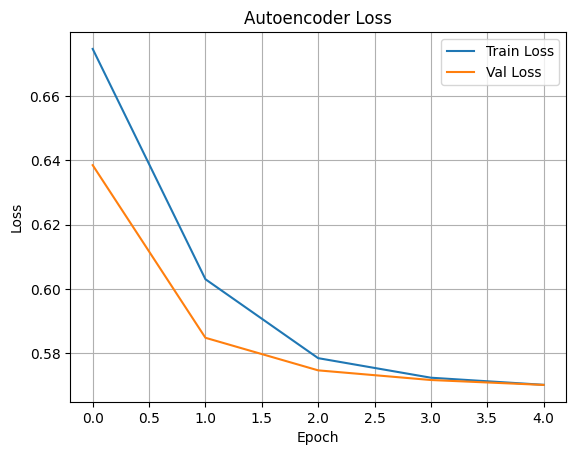

50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
Encoded Feature Shape: (1600, 8192)

XGBoost Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.95      0.97      0.96       200
   PNEUMONIA       0.97      0.94      0.96       200

    accuracy                           0.96       400
   macro avg       0.96      0.96      0.96       400
weighted avg       0.96      0.96      0.96       400


SVM Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.95      0.95      0.95       200
   PNEUMONIA       0.95      0.95      0.95       200

    accuracy                           0.95       400
   macro avg       0.95      0.95      0.95       400
weighted avg       0.95      0.95      0.95       400



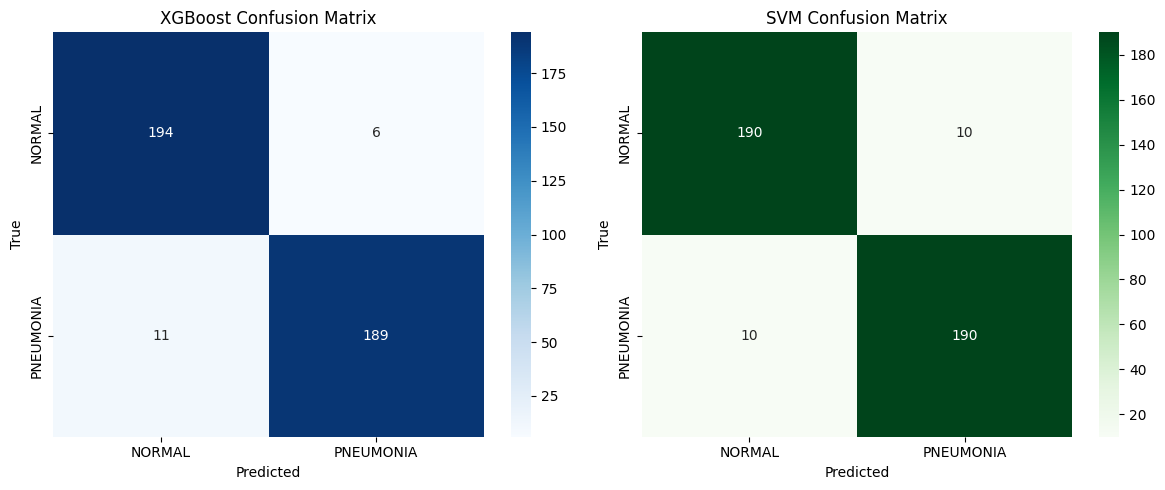

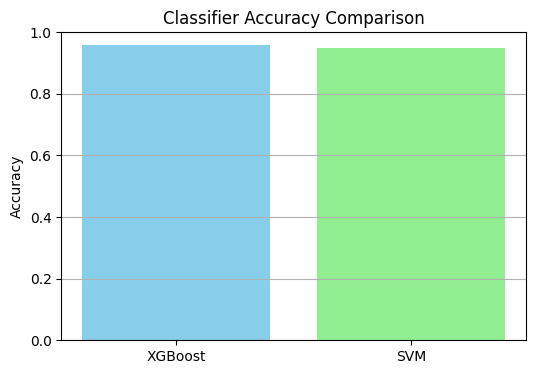

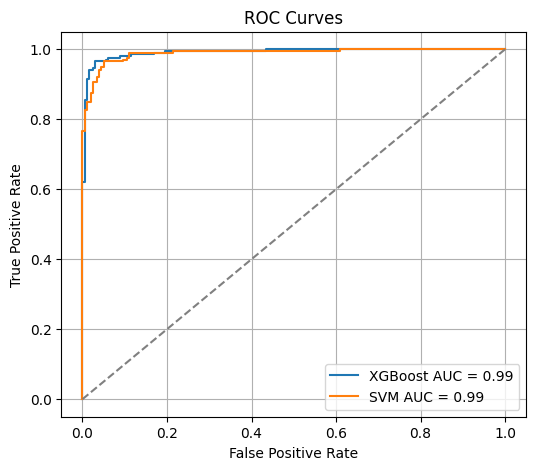

In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    roc_auc_score, roc_curve
)
from sklearn.svm import SVC
from xgboost import XGBClassifier
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam

# --- Set paths ---
base_path = "/kaggle/input/chest-xray-pneumonia/chest_xray"
train_path = os.path.join(base_path, "train")

# --- Constants ---
IMG_SIZE = (128, 128)
MAX_IMAGES = 1000
CLASS_NAMES = ['NORMAL', 'PNEUMONIA']

# --- Load dataset ---
def load_dataset(folder, img_size, max_images=None):
    X, y = [], []
    for label in CLASS_NAMES:
        path = os.path.join(folder, label)
        files = os.listdir(path)
        for i, file in enumerate(tqdm(files[:max_images], desc=f"Loading {label}")):
            img = cv2.imread(os.path.join(path, file), cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, img_size)
                X.append(img)
                y.append(CLASS_NAMES.index(label))
    return np.array(X), np.array(y)

X, y = load_dataset(train_path, IMG_SIZE, max_images=MAX_IMAGES)
X = X.astype('float32') / 255.0
X = np.reshape(X, (X.shape[0], IMG_SIZE[0], IMG_SIZE[1], 1))
print(f"Loaded images: {X.shape}, Labels: {y.shape}")

# --- Split data ---
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# --- Define Autoencoder (with correct output size) ---
input_img = Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 1))

# Encoder
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=Adam(), loss='binary_crossentropy')

# --- Train Autoencoder ---
print("Training Autoencoder...")
history = autoencoder.fit(X_train, X_train, epochs=5, batch_size=64, shuffle=True,
                          validation_split=0.1, verbose=1)

# --- Plot Training Loss ---
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Autoencoder Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# --- Feature Extraction ---
encoder = Model(input_img, encoded)
X_train_enc = encoder.predict(X_train)
X_test_enc = encoder.predict(X_test)

# Flatten encoded features
X_train_flat = X_train_enc.reshape(X_train_enc.shape[0], -1)
X_test_flat = X_test_enc.reshape(X_test_enc.shape[0], -1)
print("Encoded Feature Shape:", X_train_flat.shape)

# --- XGBoost Classifier ---
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train_flat, y_train)
xgb_preds = xgb.predict(X_test_flat)
xgb_probs = xgb.predict_proba(X_test_flat)[:, 1]

# --- SVM Classifier ---
svm = SVC(probability=True)
svm.fit(X_train_flat, y_train)
svm_preds = svm.predict(X_test_flat)
svm_probs = svm.predict_proba(X_test_flat)[:, 1]

# --- Evaluation Function ---
def evaluate_model(name, y_true, y_pred, probs):
    print(f"\n{name} Classification Report:")
    print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))
    acc = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, probs)
    return acc, auc

# --- Evaluate Both Models ---
xgb_acc, xgb_auc = evaluate_model("XGBoost", y_test, xgb_preds, xgb_probs)
svm_acc, svm_auc = evaluate_model("SVM", y_test, svm_preds, svm_probs)

# --- Confusion Matrices ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(y_test, xgb_preds), annot=True, fmt='d',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, cmap='Blues')
plt.title("XGBoost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix(y_test, svm_preds), annot=True, fmt='d',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, cmap='Greens')
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# --- Accuracy Comparison Bar Chart ---
plt.figure(figsize=(6, 4))
plt.bar(['XGBoost', 'SVM'], [xgb_acc, svm_acc], color=['skyblue', 'lightgreen'])
plt.ylabel("Accuracy")
plt.title("Classifier Accuracy Comparison")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()

# --- ROC Curves ---
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_probs)
fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_probs)

plt.figure(figsize=(6, 5))
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost AUC = {xgb_auc:.2f}')
plt.plot(fpr_svm, tpr_svm, label=f'SVM AUC = {svm_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.grid()
plt.show()


Loading PNEUMONIA: 100%|██████████| 3875/3875 [00:37<00:00, 102.03it/s]


Loaded images: (5216, 128, 128, 1), Labels: (5216,)
Training Autoencoder...
Epoch 1/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 55s 885ms/step - loss: 0.6693 - val_loss: 0.5831
Epoch 2/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 51s 872ms/step - loss: 0.5773 - val_loss: 0.5754
Epoch 3/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 52s 881ms/step - loss: 0.5719 - val_loss: 0.5732
Epoch 4/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 52s 880ms/step - loss: 0.5700 - val_loss: 0.5722
Epoch 5/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 51s 869ms/step - loss: 0.5691 - val_loss: 0.5716


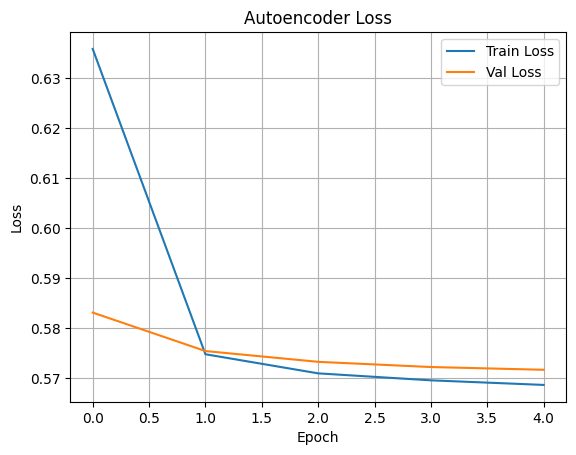

131/131 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step
Encoded Feature Shape: (4172, 8192)

XGBoost Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.93      0.92      0.93       268
   PNEUMONIA       0.97      0.98      0.97       776

    accuracy                           0.96      1044
   macro avg       0.95      0.95      0.95      1044
weighted avg       0.96      0.96      0.96      1044


SVM Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.94      0.89      0.92       268
   PNEUMONIA       0.96      0.98      0.97       776

    accuracy                           0.96      1044
   macro avg       0.95      0.94      0.94      1044
weighted avg       0.96      0.96      0.96      1044



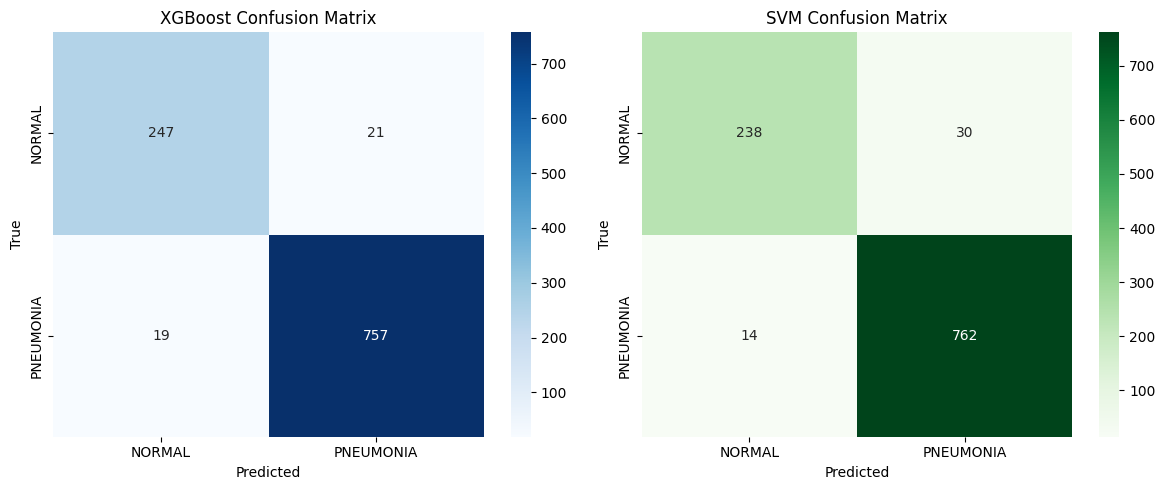

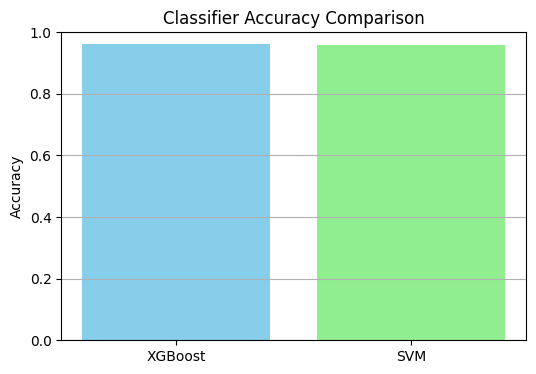

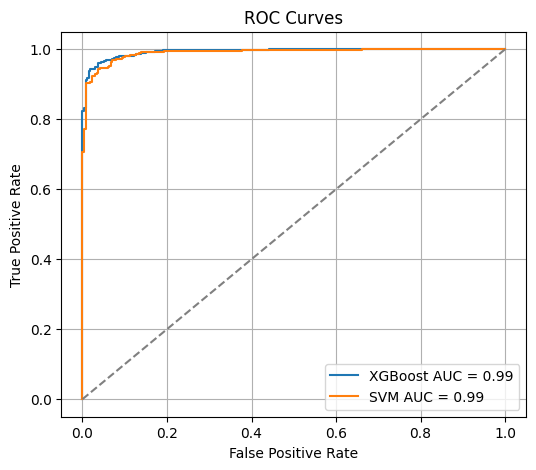

In [4]:
#KAGGLE DATASET

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    roc_auc_score, roc_curve
)
from sklearn.svm import SVC
from xgboost import XGBClassifier
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam

# --- Set paths ---
base_path = "/kaggle/input/chest-xray-pneumonia/chest_xray"
train_path = os.path.join(base_path, "train")

# --- Constants ---
IMG_SIZE = (128, 128)
MAX_IMAGES = 1000
CLASS_NAMES = ['NORMAL', 'PNEUMONIA']

# --- Load dataset ---
def load_dataset(folder, img_size, max_images=None):
    X, y = [], []
    for label in CLASS_NAMES:
        path = os.path.join(folder, label)
        files = os.listdir(path)
        for i, file in enumerate(tqdm(files[:max_images], desc=f"Loading {label}")):
            img = cv2.imread(os.path.join(path, file), cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, img_size)
                X.append(img)
                y.append(CLASS_NAMES.index(label))
    return np.array(X), np.array(y)

X, y = load_dataset(train_path, IMG_SIZE, max_images=None)
X = X.astype('float32') / 255.0
X = np.reshape(X, (X.shape[0], IMG_SIZE[0], IMG_SIZE[1], 1))
print(f"Loaded images: {X.shape}, Labels: {y.shape}")

# --- Split data ---
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# --- Define Autoencoder (with correct output size) ---
input_img = Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 1))

# Encoder
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=Adam(), loss='binary_crossentropy')

# --- Train Autoencoder ---
print("Training Autoencoder...")
history = autoencoder.fit(X_train, X_train, epochs=5, batch_size=64, shuffle=True,
                          validation_split=0.1, verbose=1)

# --- Plot Training Loss ---
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Autoencoder Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# --- Feature Extraction ---
encoder = Model(input_img, encoded)
X_train_enc = encoder.predict(X_train)
X_test_enc = encoder.predict(X_test)

# Flatten encoded features
X_train_flat = X_train_enc.reshape(X_train_enc.shape[0], -1)
X_test_flat = X_test_enc.reshape(X_test_enc.shape[0], -1)
print("Encoded Feature Shape:", X_train_flat.shape)

# --- XGBoost Classifier ---
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train_flat, y_train)
xgb_preds = xgb.predict(X_test_flat)
xgb_probs = xgb.predict_proba(X_test_flat)[:, 1]

# --- SVM Classifier ---
svm = SVC(probability=True)
svm.fit(X_train_flat, y_train)
svm_preds = svm.predict(X_test_flat)
svm_probs = svm.predict_proba(X_test_flat)[:, 1]

# --- Evaluation Function ---
def evaluate_model(name, y_true, y_pred, probs):
    print(f"\n{name} Classification Report:")
    print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))
    acc = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, probs)
    return acc, auc

# --- Evaluate Both Models ---
xgb_acc, xgb_auc = evaluate_model("XGBoost", y_test, xgb_preds, xgb_probs)
svm_acc, svm_auc = evaluate_model("SVM", y_test, svm_preds, svm_probs)

# --- Confusion Matrices ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(y_test, xgb_preds), annot=True, fmt='d',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, cmap='Blues')
plt.title("XGBoost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix(y_test, svm_preds), annot=True, fmt='d',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, cmap='Greens')
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# --- Accuracy Comparison Bar Chart ---
plt.figure(figsize=(6, 4))
plt.bar(['XGBoost', 'SVM'], [xgb_acc, svm_acc], color=['skyblue', 'lightgreen'])
plt.ylabel("Accuracy")
plt.title("Classifier Accuracy Comparison")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()

# --- ROC Curves ---
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_probs)
fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_probs)

plt.figure(figsize=(6, 5))
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost AUC = {xgb_auc:.2f}')
plt.plot(fpr_svm, tpr_svm, label=f'SVM AUC = {svm_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.grid()
plt.show()


Loading .dcm images...


100%|██████████| 26684/26684 [08:14<00:00, 53.91it/s]


Loaded 26684 DICOM images. Shape: (26684, 128, 128, 1)
Train shape: (21347, 128, 128, 1), Test shape: (5337, 128, 128, 1)


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 128, 128, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 128, 128, 16)        │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 64, 64, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 64, 64, 8)           │           1,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 32, 32, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 32, 32, 8)           │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_8 (UpSampling2D)       │ (None, 64, 64, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 64, 64, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_9 (UpSampling2D)       │ (None, 128, 128, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 128, 128, 1)         │             145 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,217 (12.57 KB)

 Trainable params: 3,217 (12.57 KB)

 Non-trainable params: 0 (0.00 B)

Training Autoencoder...
Epoch 1/5
301/301 ━━━━━━━━━━━━━━━━━━━━ 291s 954ms/step - loss: 0.6119 - val_loss: 0.5580
Epoch 2/5
301/301 ━━━━━━━━━━━━━━━━━━━━ 272s 904ms/step - loss: 0.5577 - val_loss: 0.5566
Epoch 3/5
301/301 ━━━━━━━━━━━━━━━━━━━━ 289s 960ms/step - loss: 0.5565 - val_loss: 0.5560
Epoch 4/5
301/301 ━━━━━━━━━━━━━━━━━━━━ 276s 917ms/step - loss: 0.5564 - val_loss: 0.5555
Epoch 5/5
301/301 ━━━━━━━━━━━━━━━━━━━━ 288s 956ms/step - loss: 0.5557 - val_loss: 0.5553
668/668 ━━━━━━━━━━━━━━━━━━━━ 38s 56ms/step
167/167 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step
Encoded feature shape: (21347, 8192)
Training SVM...

Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.87      4135
           1       0.73      0.01      0.02      1202

    accuracy                           0.78      5337
   macro avg       0.75      0.50      0.45      5337
weighted avg       0.77      0.78      0.68      5337

Accuracy: 0.7761


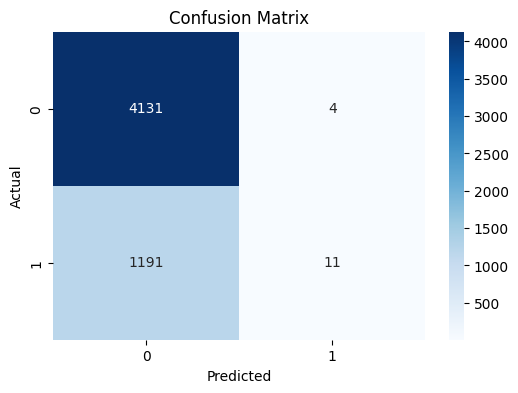

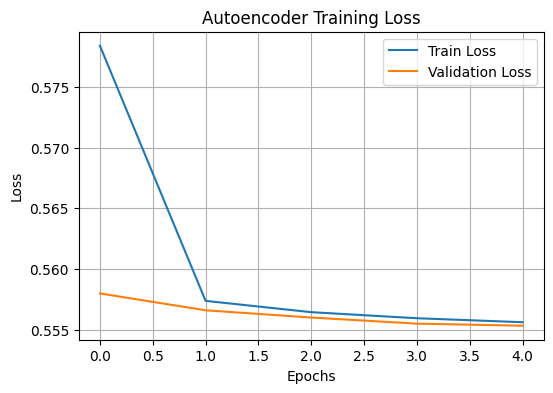

In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import pydicom
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D

# Paths
DATA_DIR = "/kaggle/input/rsna-pneumonia-detection-challenge"
IMG_DIR = os.path.join(DATA_DIR, "stage_2_train_images")
LABELS_PATH = os.path.join(DATA_DIR, "stage_2_train_labels.csv")

# Parameters
IMG_SIZE = 128
MAX_IMAGES = None  # Set None to use all

# Load labels
df = pd.read_csv(LABELS_PATH)
df = df.drop_duplicates(subset='patientId')  # one label per patient
df['label'] = df['Target']  # 1 = Pneumonia, 0 = Normal

# Load and preprocess DICOM images
X, y = [], []
print("Loading .dcm images...")

for _, row in tqdm(df.iterrows(), total=len(df)):
    dcm_path = os.path.join(IMG_DIR, row['patientId'] + ".dcm")
    if not os.path.exists(dcm_path): continue

    try:
        ds = pydicom.dcmread(dcm_path)
        img = ds.pixel_array.astype(np.float32)
        img = Image.fromarray(img).resize((IMG_SIZE, IMG_SIZE)).convert("L")
        X.append(np.array(img))
        y.append(row['label'])

        if MAX_IMAGES and len(X) >= MAX_IMAGES:
            break
    except:
        continue

X = np.array(X).astype("float32") / 255.
X = np.expand_dims(X, axis=-1)
y = np.array(y)

print(f"Loaded {len(X)} DICOM images. Shape: {X.shape}")

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

# Define Autoencoder
input_img = Input(shape=(IMG_SIZE, IMG_SIZE, 1))
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

# Train autoencoder
print("Training Autoencoder...")
history = autoencoder.fit(X_train, X_train, epochs=5, batch_size=64,
                          validation_split=0.1, shuffle=True, verbose=1)

# Extract features using encoder
encoder = Model(inputs=autoencoder.input, outputs=encoded)
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)
X_train_flat = X_train_encoded.reshape(len(X_train_encoded), -1)
X_test_flat = X_test_encoded.reshape(len(X_test_encoded), -1)

print(f"Encoded feature shape: {X_train_flat.shape}")

# Train SVM
print("Training SVM...")
svm = SVC()
svm.fit(X_train_flat, y_train)

# Predictions and evaluation
y_pred = svm.predict(X_test_flat)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_.astype(str)))

acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}")

# Confusion Matrix
plt.figure(figsize=(6, 4))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Loss plot
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Autoencoder Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


In [7]:
!pip install -q pydicom


Loading and preprocessing DICOM images...


100%|██████████| 26684/26684 [17:38<00:00, 25.21it/s]


Train shape: (21347, 128, 128, 1), Test shape: (5337, 128, 128, 1)
Training Autoencoder...
Epoch 1/5
301/301 ━━━━━━━━━━━━━━━━━━━━ 462s 2s/step - loss: 0.2213 - val_loss: 0.0664
Epoch 2/5
301/301 ━━━━━━━━━━━━━━━━━━━━ 473s 2s/step - loss: 0.0663 - val_loss: 0.0663
Epoch 3/5
301/301 ━━━━━━━━━━━━━━━━━━━━ 500s 2s/step - loss: 0.0662 - val_loss: 0.0662
Epoch 4/5
301/301 ━━━━━━━━━━━━━━━━━━━━ 471s 2s/step - loss: 0.0662 - val_loss: 0.0662
Epoch 5/5
301/301 ━━━━━━━━━━━━━━━━━━━━ 453s 2s/step - loss: 0.0661 - val_loss: 0.0661
668/668 ━━━━━━━━━━━━━━━━━━━━ 55s 83ms/step
167/167 ━━━━━━━━━━━━━━━━━━━━ 14s 82ms/step
Training XGBoost Classifier...

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.86      0.83      4135
           1       0.34      0.26      0.29      1202

    accuracy                           0.72      5337
   macro avg       0.57      0.56      0.56      5337
weighted avg       0.69      0.72      0.71      5337



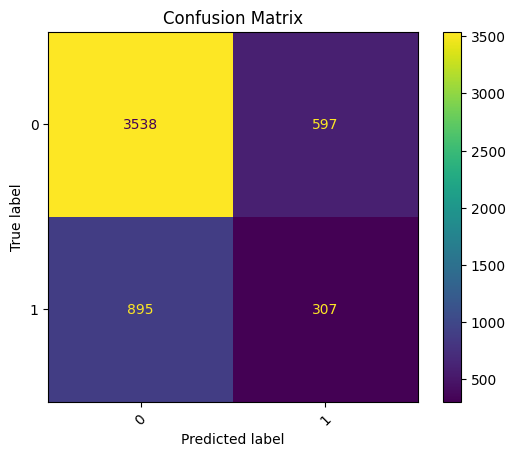

In [8]:
#RSNA DATASET

# Updated full pipeline with all recommended preprocessing techniques and a complete model using Autoencoder + XGBoost

import os
import numpy as np
import pandas as pd
import cv2
import pydicom
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam

# Constants
IMG_SIZE = 128
DATA_DIR = "/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images"
LABELS_CSV = "/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv"

# Preprocessing Functions
def apply_clahe(img):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(img)

def preprocess_dicom(path):
    try:
        ds = pydicom.dcmread(path)
        img = ds.pixel_array

        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = np.uint8(255 * (img - np.min(img)) / (np.max(img) - np.min(img)))  # Normalize to [0, 255]
        img = apply_clahe(img)
        img = cv2.fastNlMeansDenoising(img, None, 10, 7, 21)
        img = img.astype(np.float32) / 255.0
        return np.expand_dims(img, axis=-1)
    except:
        return None

# Load labels and map filenames to class
labels_df = pd.read_csv(LABELS_CSV)
labels_df = labels_df.drop_duplicates("patientId")
labels_df["Target"] = labels_df["Target"].astype(str)
label_map = dict(zip(labels_df["patientId"], labels_df["Target"]))

# Load and preprocess images
X, y = [], []
all_files = os.listdir(DATA_DIR)
print("Loading and preprocessing DICOM images...")
for fname in tqdm(all_files):
    pid = fname.replace(".dcm", "")
    if pid not in label_map:
        continue
    fpath = os.path.join(DATA_DIR, fname)
    img = preprocess_dicom(fpath)
    if img is not None:
        X.append(img)
        y.append(label_map[pid])
X = np.array(X)
y = np.array(y)

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

# Define Autoencoder
def build_autoencoder(input_shape):
    input_img = Input(shape=input_shape)

    x = Conv2D(32, (3, 3), activation="relu", padding="same")(input_img)
    x = MaxPooling2D((2, 2), padding="same")(x)
    x = Conv2D(16, (3, 3), activation="relu", padding="same")(x)
    encoded = MaxPooling2D((2, 2), padding="same")(x)

    x = Conv2D(16, (3, 3), activation="relu", padding="same")(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

    return Model(input_img, decoded)

# Build and train autoencoder
autoencoder = build_autoencoder((IMG_SIZE, IMG_SIZE, 1))
autoencoder.compile(optimizer=Adam(), loss="binary_crossentropy")
print("Training Autoencoder...")
autoencoder.fit(X_train, X_train, epochs=5, batch_size=64, validation_split=0.1, verbose=1)

# Extract encoded features
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.layers[4].output)
X_train_enc = encoder.predict(X_train).reshape(len(X_train), -1)
X_test_enc = encoder.predict(X_test).reshape(len(X_test), -1)

# XGBoost Classifier
print("Training XGBoost Classifier...")
imbalance_ratio = (len(y_train) - sum(y_train)) / sum(y_train)
model = XGBClassifier(scale_pos_weight=imbalance_ratio, use_label_encoder=False, eval_metric="logloss")
model.fit(X_train_enc, y_train)

# Predict and evaluate
y_pred = model.predict(X_test_enc)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()
